# 1. Import Data

In [2]:
# import libraries
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
 
def open_json_data(fileLocation = 'train-1.json'):
    # Opening JSON file
    openFile = open(fileLocation)
    dictionary = json.load(openFile)
    # return pd.DataFrame(dictionary)[:10]
    return pd.DataFrame(dictionary)

# 2. Process data


## Dummy builders

### Get sparseDummies

### Get Dummies from single input

In [3]:
def dummy(data, dummy_column, delete_cat = True, spase= False):
    ## create dummy
    dummy = pd.get_dummies(data[dummy_column],prefix=dummy_column, drop_first=True, sparse=spase)
    # print('dummy', dummy.shape)
    data = pd.concat([data, dummy], axis=1)
    ## drop the original categorical column
    if delete_cat : return data.drop(dummy_column, axis=1)
    return data

### Get Dummies from list

In [4]:
def dummies_from_nestedList(data, dummy_column):
    ## create dummy
    print(data)
    dummy = pd.get_dummies(data[dummy_column, 1].apply(pd.Series).stack()).sum(level=0)
    print('dummy', dummy.shape)
    data = pd.concat([data, dummy], axis=1)
    ## drop the original categorical column
    # if delete_cat : return data.drop(dummy_column, axis=1)
    return data

## Year Data

### Adding the categorical years


In [5]:
def get_years(data, return_with_dummy= False):
    conditions = [
        (data['year'] < 2000),
        (data['year'] >= 2000) & (data['year'] <= 2010),
        (data['year'] > 2010) & (data['year'] < 2016),
        (data['year'] >= 2016)
    ]
    values = [1, 2, 3, 4]
    data['class_year'] = np.select(conditions, values)
    if return_with_dummy : return dummy(data,"class_year")
    return data

## References

### Adding Categorical References

In [6]:
def get_ref(file, return_with_dummy= False):
    conditions = [
        (file['references'] <12),
        (file['references'] > 12) & (file['references'] <= 18),
        (file['references'] > 18) & (file['references'] < 21),
        (file['references'] > 21) & (file['references'] < 25),
        (file['references'] > 25) & (file['references'] < 29),
        (file['references'] > 29) & (file['references'] < 33),
        (file['references'] > 33) & (file['references'] < 38),
        (file['references'] > 38) & (file['references'] < 45),
        (file['references'] > 45) & (file['references'] < 55),
        (file['references'] >= 55)
    ]
    values = [1, 2, 3, 4, 5, 6 ,7 ,8,9,10]
    file['class_ref'] = np.select(conditions, values)
    if return_with_dummy : return dummy(file,"class_ref")
    return file

## Generic Data process

### Fill Nan

In [7]:
def fill_Nan(data):
    data['year'] = data['year'].fillna(data['references'].mean())
    data['references'] = data['references'].fillna(0)
    data["fields_of_study"] = data["fields_of_study"].fillna("")
    data["title"] = data["title"].fillna("")
    return data

## Length calculators

### Title length


In [8]:
def get_titleLen(data):
    data["title_len"] = data.apply(lambda x:len(x["title"]),axis=1)
    return data

### Authors length

In [9]:
def get_AuthorsLen(data):
    data["authors_len"] = data.apply(lambda x:len(x["authors"]),axis=1)
    return data

### Topics Length

In [10]:
def get_TopicsLen(data):
    data["topics_len"] = data.apply(lambda x:len(x["topics"]),axis=1)
    return data

### Fields of Study Length

In [11]:
def get_FieldsOfStudyLen(data):
    data["fields_of_study_len"] = data.apply(lambda x:len(x["fields_of_study"]),axis=1)
    return data


## Venue

### Generate Venue Data

In [12]:
data_set = np.array([ [x['venue'], x['citations']] for x in json.load(open('train-1.json')) if x['venue']])

def get_cat(dataFrame):
    conditions = [
        (dataFrame['cumsum'] == 0),
        (dataFrame['cumsum'] > 0) & (dataFrame['cumsum'] <= 10),
        (dataFrame['cumsum'] > 10) & (dataFrame['cumsum'] <= 20),
        (dataFrame['cumsum'] > 20) & (dataFrame['cumsum'] <= 30),
        (dataFrame['cumsum'] > 30) & (dataFrame['cumsum'] <= 40),
        (dataFrame['cumsum'] > 40) & (dataFrame['cumsum'] <= 50),
        (dataFrame['cumsum'] > 50) & (dataFrame['cumsum'] <= 60),
        (dataFrame['cumsum'] > 60) & (dataFrame['cumsum'] <= 70),
        (dataFrame['cumsum'] > 70) & (dataFrame['cumsum'] <= 80),
        (dataFrame['cumsum'] > 80) & (dataFrame['cumsum'] <= 90),
        (dataFrame['cumsum'] > 90) & (dataFrame['cumsum'] <= 92),
        (dataFrame['cumsum'] > 92) & (dataFrame['cumsum'] <= 94),
        (dataFrame['cumsum'] > 94) & (dataFrame['cumsum'] <= 96),
        (dataFrame['cumsum'] > 96) & (dataFrame['cumsum'] <= 98),
        (dataFrame['cumsum'] >= 98)
    ]
    values = [1,2,3,4,5,6,7,8,9,10,11,13,14,15,16]
    dataFrame['class_Venue'] = np.select(conditions, values)
    return dataFrame

def get_venue_dictionary(XY):
    #split data 
    X, _ = np.split(XY, 2, 1)
    
    unique_X = np.unique(X,return_counts=True)
    unique_X_length = len(unique_X[0])
    print(unique_X_length)
    zero_array = np.zeros((3,unique_X_length))

    merge = [unique_X[0], unique_X[1].astype(int), zero_array[0].astype(int), zero_array[1].astype(int), zero_array[2].astype(float)]
    
    # Compute citations per topic
    for x in XY :
        merge[2][np.where(merge[0] == x[0])[0][0]] += int(x[1])

    # Compute citations per topic divided by the amount of articles
    for (i, j) in enumerate(merge[3]):
        merge[3][i] = (merge[2][i]/merge[1][i])

    # Compute new summed citations
    summed_citations = np.sum(merge[3])
    result = []
    for (i, j) in enumerate(merge[3]):
        merge[4][i] = 100/summed_citations*merge[3][i]
        result.append((merge[0][i],merge[1][i],merge[2][i],merge[3][i],merge[4][i]))
    
    dtype = [('venue', 'S100'), ('count', int), ('summed_citations', int), ('average_citations', float), ('contribution', float)]
    
    structured_array = np.array(result, dtype=dtype)
    sorted = np.sort(structured_array, order='contribution')
    df = pd.DataFrame(sorted)
    df['cumsum'] = df['contribution'].cumsum(axis=0)
    df = get_cat(df)
    return df
get_venue_dictionary(data_set).to_pickle("venue_data.pkl")

299


### Find venue data

In [13]:
def find_venue_in_dataFrame(venue, venues_dict):
    venue_cat = venues_dict[venues_dict["venue"].str.decode("utf-8")  == venue]
    if len(venue_cat)>0 : return venue_cat.iloc[0]['class_Venue']
    return 0

def get_venue(data):
    venue_dictionary = pd.read_pickle("venue_data.pkl")
    data["venue_cat"] = data.apply(lambda x:find_venue_in_dataFrame(x.venue, venue_dictionary),axis=1)
    return data


## Topics

### Generate Topic Data

In [14]:
data_set = np.array([ [x['topics'], x['citations']] for x in json.load(open('train-1.json')) if x['topics']])

def get_cat(dataFrame):
    conditions = [
        (dataFrame['cumsum'] == 0),
        (dataFrame['cumsum'] > 0) & (dataFrame['cumsum'] <= 10),
        (dataFrame['cumsum'] > 10) & (dataFrame['cumsum'] <= 20),
        (dataFrame['cumsum'] > 20) & (dataFrame['cumsum'] <= 30),
        (dataFrame['cumsum'] > 30) & (dataFrame['cumsum'] <= 40),
        (dataFrame['cumsum'] > 40) & (dataFrame['cumsum'] <= 50),
        (dataFrame['cumsum'] > 50) & (dataFrame['cumsum'] <= 60),
        (dataFrame['cumsum'] > 60) & (dataFrame['cumsum'] <= 70),
        (dataFrame['cumsum'] > 70) & (dataFrame['cumsum'] <= 80),
        (dataFrame['cumsum'] > 80) & (dataFrame['cumsum'] <= 90),
        (dataFrame['cumsum'] > 90)
    ]
    values = [0,1, 2, 3, 4,5,6,7,8,9,10]
    dataFrame['class_topic'] = np.select(conditions, values)
    return dataFrame

def unique_Array_of_nested_array(x):
    topics_array = list(map((lambda z: z[0]), x))
    topics_array = np.concatenate(topics_array)
    return np.unique(topics_array,return_counts=True)

def get_venue_dictionary(XY):
    #split data 
    X, _ = np.split(XY, 2, 1)

    # Get unique topics
    unique_topics = unique_Array_of_nested_array(X)
    unique_topics_lenght = len(unique_topics[0])

    # Generate 0 arrays in order to fill them with the counts
    zero_arrays = np.zeros((3,unique_topics_lenght))

    # Merge arrays together
    merge = [unique_topics[0], unique_topics[1].astype(int), zero_arrays[0].astype(int), zero_arrays[1].astype(int), zero_arrays[2].astype(float)]

    # Compute citations per topic
    for x in XY :
        for topic in x[0]:
            merge[2][np.where(merge[0] == topic)[0][0]] += int(x[1])


    # Compute citations per topic divided by the amount of articles
    for (i, j) in enumerate(merge[3]):
        merge[3][i] = (merge[2][i]/merge[1][i])

    # Compute new summed citations
    summed_citations = np.sum(merge[3])

    result = []
    # Compute percentage of new total sum
    for (i, j) in enumerate(merge[3]):
        merge[4][i] = 100/summed_citations*merge[3][i]
        result.append((merge[0][i],merge[1][i],merge[2][i],merge[3][i],merge[4][i]))

    dtype = [('topic', 'str'), ('count', int), ('summed_citations', int), ('average_citations', float), ('contribution', float)]
    structured_array = np.array(result, dtype=dtype)

    sorted = np.sort(structured_array, order='contribution')
    df = pd.DataFrame(sorted)
    df['cumsum'] = df['contribution'].cumsum(axis=0)
    df = get_cat(df)
    return df
get_venue_dictionary(data_set).to_pickle("topic_data.pkl")

<ipython-input-14-538f5a88a746>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_set = np.array([ [x['topics'], x['citations']] for x in json.load(open('train-1.json')) if x['topics']])


### Extract topic data

## Abstract
 

### Abstract Vector

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def create_countVector():
    train_data = [ x['abstract'] for x in json.load(open('train-1.json')) if x['abstract']]
    tfIdfTransformer = TfidfTransformer(use_idf=True)
    countVectorizer = CountVectorizer()
    wordCount = countVectorizer.fit_transform(train_data)
    newTfIdf = tfIdfTransformer.fit_transform(wordCount)
    df = pd.DataFrame(newTfIdf[0].T.todense(), index = countVectorizer.get_feature_names(), columns = ["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending = False)

create_countVector()


# Figures

## Plot single line

In [16]:
import matplotlib.pyplot as plt
def plotY(Y):
    Y = np.array(Y)
    Y = np.sort(Y)
    plt.plot(Y)
    return plt.show()

## Plot 2 lines

In [17]:
import matplotlib.pyplot as plt
def plotY2(Ypred,Yreal):
    length = len(Ypred)
    plt.plot(Yreal,'b')
    plt.plot(Ypred,'r')
    return plt.show()

## Histogram

In [18]:
def PlotHistY(Y):
    plt.hist(x=Y, bins=20)
    plt.show()

# Model

## Evaluation

In [19]:
from sklearn import metrics

def eval(predicted, y_test):
    ## Kpi
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test - predicted) / predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
            "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    ## residuals
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(
        residuals).index(min(residuals))
    # max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    return(residuals,max_error,max_idx)

## Models

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR,LinearSVR
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor,VotingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

def modelCalculators(X_train, y_train, X_val, y_val, train=True):
    # sdgRegres = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100000, tol=1e-3))
    # sdgRegres.fit(X_train, y_train)
    # sdgRegres_score = sdgRegres.score(X_val, y_val)
    # sdgRegres_transformed = sdgRegres.predict(X_val)
    # sdgRegres_pred = np.exp(sdgRegres_transformed)
    # print('SDG',sdgRegres_score)


    linearRidg = make_pipeline(StandardScaler(), linear_model.Ridge(alpha=1.1))
    # linearRidg.fit(X_train, y_train)
    # linearRidg_score = linearRidg.score(X_val, y_val)
    # linearRidg_transformed = linearRidg.predict(X_val)
    # linearRidg_pred = np.exp(linearRidg_transformed)
    # print('Ridg',linearRidg_score)
    
    linearLasso = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=1.1, selection='random'))
    # linearLasso.fit(X_train, y_train)
    # linearLasso_score = linearLasso.score(X_val, y_val)
    # linearLasso_transformed = linearLasso.predict(X_val)
    # linearLasso_pred = np.exp(linearLasso_transformed)
    # print('Lasso',linearLasso_score)

    svrRegress = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='rbf', degree=4))
    # svrRegress.fit(X_train, y_train)
    # svrRegress_score = svrRegress.score(X_val, y_val)
    # svrRegress_transformed = svrRegress.predict(X_val)
    # svrRegress_pred = np.exp(svrRegress_transformed)
    # print('SVR Regress',svrRegress_score)

    linearSVR = make_pipeline(StandardScaler(), LinearSVR(random_state=0,max_iter=100000, tol=1e-5))
    # linearSVR.fit(X_train, y_train)
    # linearSVR_score = linearSVR.score(X_val, y_val)
    # linearSVR_transformed = linearSVR.predict(X_val)
    # linearSVR_pred = np.exp(linearSVR_transformed)
    # print('SVR Lin',linearSVR_score)

    adaBoostReg = AdaBoostRegressor(random_state=0, n_estimators=100)
    # adaBoostReg.fit(X_train, y_train)
    # adaBoostReg_score = adaBoostReg.score(X_val, y_val)
    # adaBoostReg_transformed = adaBoostReg.predict(X_val)
    # adaBoostReg_pred = np.exp(adaBoostReg_transformed)
    # print('Ada',adaBoostReg_score)

    regressionVoted = VotingRegressor([('Ridg', linearRidg),('SVR', svrRegress),('ada', adaBoostReg), ('linearSVR', linearSVR)],n_jobs=-1)
    regressionVoted.fit(X_train, y_train)
    
    if train : 
        regressionVoted_score = regressionVoted.score(X_val, y_val)
        print('Voted',regressionVoted_score)

    regressionVoted_transformed = regressionVoted.predict(X_val)
    regressionVoted_pred = np.exp(regressionVoted_transformed)
    

    # params = {
    #     'lr__C': [1.0, 100.0],
    #     'svm__C': [2,3,4],
    # }

    # grid = GridSearchCV(estimator=regressionVoted, param_grid=params, cv=2, n_jobs=-1)
    # grid.fit(X_train,y_train)
    # grid_score = grid.score(X_val, y_val)
    # grid_transformed = grid.predict(X_val)
    # grid_pred = np.exp(grid_transformed)
    # print('Grid', grid_score)

    return regressionVoted_pred

## Data transformation

In [62]:
def transformData(data):
    data = fill_Nan(data)
    data = get_ref(data, True)
    data = get_years(data, True)    
    data = get_titleLen(data)
    data = get_FieldsOfStudyLen(data)
    data = get_TopicsLen(data)
    data = get_AuthorsLen(data)
    data = get_venue(data)

    data = data.assign(fields_of_study_len2 = lambda x: x['fields_of_study_len'] * x['fields_of_study_len'])
    data = data.assign(fields_of_study_len3 = lambda x: x['fields_of_study_len'] * x['fields_of_study_len'] * x['fields_of_study_len'])
    data = data.assign(topicsLen2 = lambda x: x['topics_len'] * x['topics_len'])
    data = data.assign(topicsLen3 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len'])
    data = data.assign(topicsLen4 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len']* x['topics_len'])
    data = data.assign(topicsLen5 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len']* x['topics_len']* x['topics_len'])
    data = data.assign(authorsLen2 = lambda x: x['authors_len'] * x['authors_len'])
    data = data.assign(topicsFoS = lambda x: x['topics_len'] * x['fields_of_study_len'])
    data = data.assign(topicsVenueCat = lambda x: x['topics_len'] * x['venue_cat'])
    data = data.assign(references2 = lambda x: x['references'] * x['references'])
    data = data.assign(references3 = lambda x: x['references'] * x['references']* x['references'])
    data = data.assign(references4 = lambda x: x['references'] * x['references']* x['references']* x['references'])
    return data

## Create X

In [22]:
def return_x(data, train=True):
    if train : return data.drop(["citations", "year", "doi", "title", "abstract", "authors", "topics","fields_of_study", "venue"], axis=1).values
    return data.drop(["year", "doi", "title", "abstract", "authors", "topics","fields_of_study", "venue"], axis=1).values

## Training

The function will consist of two steps, first the program will load all the data and process this. This is necessary in order to know the relative contribution of different variables. Then it will split the data file in two sections, train and test in order to know the respective progress of the learning task.

(9658, 41)
SVR Regress 0.42337044400638213
Voted 0.4329562640627489


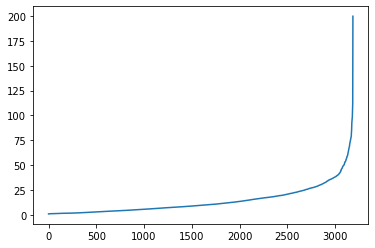

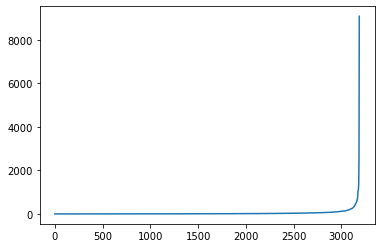

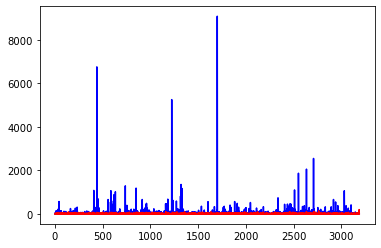

R2 (explained variance): 0.01
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 2.18
Mean Absolute Error (Σ|y-pred|/n): 36
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 247
Max Error: 9,079
[  0.89749744   0.92813754   0.99477793 ... 112.13656629 140.97663554
 199.7538643 ]


In [ ]:
def model(): 
    data = open_json_data()

    data = transformData(data)
    print(data.shape)
            
    X = return_x(data)
    y = data["citations"].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=2000)
    
    y_train_transformed = np.log1p(y_train)
    y_val_transformed = np.log1p(y_val)

    pred_y = modelCalculators(X_train, y_train_transformed, X_val, y_val_transformed)
    # pred_y[pred_y < 0] = 0
    
    plotY(pred_y)
    plotY(y_val)
    plotY2(pred_y, y_val)
    eval(pred_y, y_val)
    YpredSorted = np.sort(pred_y)
    print(YpredSorted)
    return

model()

# Test generator

(9658, 41)
(1000, 40)
[         0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          1
          1          1          1       

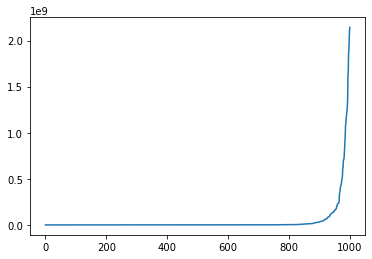

In [65]:
def model(): 
    data = open_json_data()
    data = transformData(data)
    print(data.shape)

    data_test = open_json_data('test.json')
    data_test_final = open_json_data('test.json')
    data_test = transformData(data_test)
    print(data_test.shape)

    
    X = return_x(data)
    y = data["citations"].values

    X_test = return_x(data_test, False)

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.33, random_state=2000)

    y_train_transformed = np.log1p(y_train)

    predictions = modelCalculators(X_train, y_train_transformed, X_test,[], False)

    Ypred = pd.Series(predictions.astype(int))
    Ypred = Ypred.where(Ypred > 0, 0)
    
    data_test_final["citations"] = Ypred.astype('int')

    YpredSorted = np.sort(Ypred)
    print(YpredSorted)
    plotY(Ypred)
   
    return data_test_final.drop(["year", "references", "is_open_access","title", "abstract", "authors", "topics","fields_of_study", "venue"], axis=1)

model().to_json("predicted.json", orient='records')